In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# dataset path
environment = ''
def colab_or_not():
  if 'google.colab' in sys.modules:
    global environment
    from google.colab import drive
    print('Running in Google Colab')
    # Colab-specific code here
    !echo "Colab specific command"
    drive.mount('/content/drive')
    environment = 'colab'
    print(os.getcwd())
  else:
    print('Not running in Google Colab')
    # Non-Colab code here
    environment = 'local'
    print(os.getcwd())

colab_or_not()
print(environment)

Running in Google Colab
Colab specific command
Mounted at /content/drive
/content
colab


In [3]:
# read shape predictors
if environment == 'colab':
  landmark_predictor = dlib.shape_predictor("/content/drive/My Drive/aml/shape_predictor_68_face_landmarks.dat")
else:
  # !FIX
  print('not colab')

# Preprocessing

In [4]:
# Load dlib's face detector and facial landmark predictor
face_detector = dlib.get_frontal_face_detector()

# Define a function to align faces
"""def align_face(image, reference_landmarks, output_size=(256, 256)):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)

    if len(faces) == 0:
        raise ValueError("No faces detected in the image.")

    # Use the first detected face
    face = faces[0]
    landmarks = landmark_predictor(gray, face)

    # Extract the facial landmarks
    input_landmarks = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

    # Compute the transformation matrix
    transformation_matrix, _ = cv2.estimateAffinePartial2D(input_landmarks, reference_landmarks)

    # Apply the transformation to align the face
    aligned_face = cv2.warpAffine(image, transformation_matrix, output_size, flags=cv2.INTER_LINEAR)

    return aligned_face"""

def align_face(image, reference_landmarks, output_size=(256, 256)):
    """
    Aligns the face in the input image to a reference set of landmarks.

    Parameters:
        image (numpy.ndarray): Input image.
        reference_landmarks (numpy.ndarray): Array of reference facial landmarks.
        output_size (tuple): Desired output size of the aligned face.

    Returns:
        numpy.ndarray: Aligned face image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)

    if len(faces) == 0:
        raise ValueError("No faces detected in the image.")

    # Use the first detected face
    face = faces[0]
    landmarks = landmark_predictor(gray, face)

    # Extract 5 specific points for alignment (eyes, nose tip, and mouth corners)
    indices = [36, 45, 30, 48, 54]  # Left eye, right eye, nose tip, left mouth, right mouth
    input_landmarks = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in indices])

    # Compute the transformation matrix
    transformation_matrix, _ = cv2.estimateAffinePartial2D(input_landmarks, reference_landmarks)

    # Apply the transformation to align the face
    aligned_face = cv2.warpAffine(image, transformation_matrix, output_size, flags=cv2.INTER_LINEAR)

    return aligned_face

# Update reference landmarks to match the indices above
reference_landmarks = np.array([
    [30.2946, 51.6963],  # Left eye
    [65.5318, 51.5014],  # Right eye
    [48.0252, 71.7366],  # Nose tip
    [33.5493, 92.3655],  # Left mouth corner
    [62.7299, 92.2041]   # Right mouth corner
])
reference_landmarks *= (256 / 96)  # Scale for 256x256 resolution


## Testing Alignment

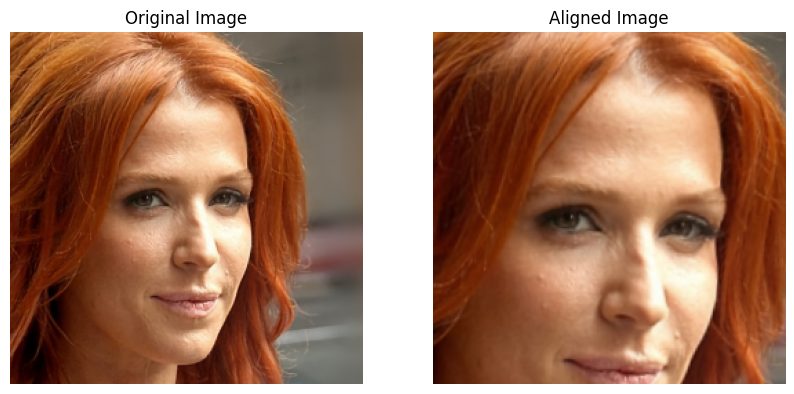

In [5]:
input_image = cv2.imread("/content/drive/My Drive/aml/celebAhq256small/img_2.png")
if input_image is None:
    raise ValueError("Failed to load the test image. Please provide a valid image.")

# Define a reference face with frontal alignment (predefined landmarks for 128x128 resolution)
reference_landmarks = np.array([
    [30.2946, 51.6963], [65.5318, 51.5014], [48.0252, 71.7366], [33.5493, 92.3655], [62.7299, 92.2041]
])
reference_landmarks *= (256 / 96)  # Scale for 256x256 resolution

# Align the face
try:
    aligned_image = align_face(input_image, reference_landmarks)

    # Show the input and aligned images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Aligned Image")
    plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()
except ValueError as e:
    print(str(e))

# Masking
The paper assumes pre-given masks, we do not.

In [6]:
# Define a function for creating a segmentation mask
def generate_segmentation_mask(image, use_manual_mask=False, manual_mask_path=None):
    """
    Generates a segmentation mask for the input image.

    Parameters:
        image (numpy.ndarray): Input image.
        use_manual_mask (bool): Whether to use a manual mask.
        manual_mask_path (str): Path to the manual mask, if applicable.

    Returns:
        numpy.ndarray: Segmentation mask (binary image).
    """
    if use_manual_mask and manual_mask_path:
        # Load a pre-existing manual mask
        mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load manual mask from {manual_mask_path}.")
    else:
        # Simplistic approach: thresholding to create a rough mask
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

    return mask

# Define a function for seamless cloning
def apply_seamless_cloning(source_face, background_image, mask):
    """
    Applies seamless cloning to combine the source face with the background.

    Parameters:
        source_face (numpy.ndarray): Face-swapped region.
        background_image (numpy.ndarray): Original input image.
        mask (numpy.ndarray): Segmentation mask.

    Returns:
        numpy.ndarray: Final blended image.
    """
    # Get the center of the face region
    center = (background_image.shape[1] // 2, background_image.shape[0] // 2)

    # Apply seamless cloning
    output = cv2.seamlessClone(source_face, background_image, mask, center, cv2.NORMAL_CLONE)
    return output

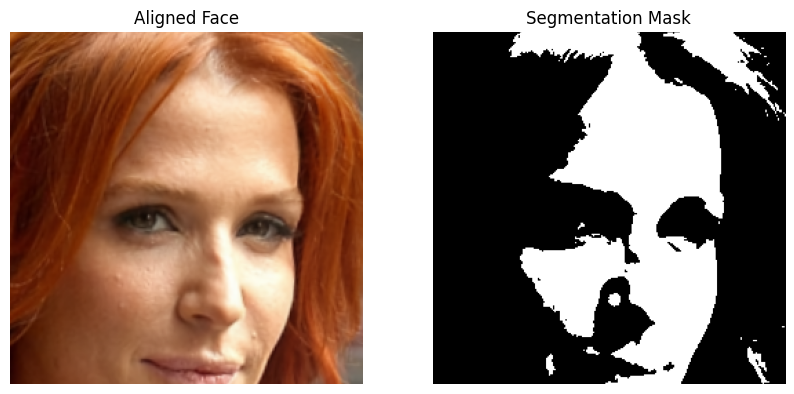

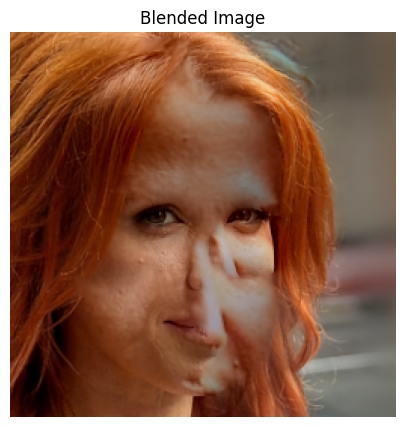

In [7]:
# Testing Segmentation
# Load the aligned image (or original image for testing)
aligned_face = aligned_image  # Replace with output from alignment step if needed

# Generate the segmentation mask
try:
    segmentation_mask = generate_segmentation_mask(aligned_face, use_manual_mask=False)

    # Visualize the segmentation mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Aligned Face")
    plt.imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    plt.imshow(segmentation_mask, cmap="gray")
    plt.axis("off")

    plt.show()
except ValueError as e:
    print(str(e))

# Apply seamless cloning (use aligned_face as a placeholder for the swapped face)
try:
    background_image = input_image  # Original image as background
    blended_image = apply_seamless_cloning(aligned_face, background_image, segmentation_mask)

    # Visualize the blended result
    plt.figure(figsize=(10, 5))
    plt.title("Blended Image")
    plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
except Exception as e:
    print(str(e))

In [8]:
# prompt: Write a function, which tests the blending for 10 images

import glob
import random

def test_blending(num_images=10):
    """Tests the blending process for a specified number of images."""

    # image_paths = glob.glob("/content/drive/My Drive/aml/celebAhq256small/*.png")
    image_paths = glob.glob("/content/drive/My Drive/aml/celebAhq/*.png")

    if not image_paths:
        print("No images found in the specified directory.")
        return

    # Select a random subset of images
    selected_image_paths = random.sample(image_paths, min(num_images, len(image_paths)))

    for image_path in selected_image_paths:
        try:
            input_image = cv2.imread(image_path)
            if input_image is None:
                print(f"Failed to load image: {image_path}")
                continue

            aligned_image = align_face(input_image, reference_landmarks)
            segmentation_mask = generate_segmentation_mask(aligned_image, use_manual_mask=False)
            blended_image = apply_seamless_cloning(aligned_image, input_image, segmentation_mask)

            # You might want to save or further process the blended_image here
            # Example: cv2.imwrite(f"blended_{os.path.basename(image_path)}", blended_image)

            # Display or process the blended image as needed
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Blended Image: {os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

# Call the function to test blending for 10 images
test_blending()

No images found in the specified directory.


In [9]:
# Function to prepare dataset
"""
    Aligns and generates segmentation masks for a dataset of images.

    Parameters:
        image_dir (str): Directory containing input images.
        output_dir (str): Directory to save aligned faces and masks.
        num_images (int): Number of images to process.

    Returns:
        None
    """
'''def prepare_dataset(image_dir, output_dir, num_images=100):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_paths = glob.glob(os.path.join(image_dir, "*.png"))[:num_images]

    for image_path in image_paths:
        try:
            input_image = cv2.imread(image_path)
            if input_image is None:
                print(f"Failed to load image: {image_path}")
                continue

            aligned_face = align_face(input_image, reference_landmarks)
            segmentation_mask = generate_segmentation_mask(aligned_face, use_manual_mask=False)

            # Save aligned face and mask
            base_name = os.path.basename(image_path)
            aligned_face_path = os.path.join(output_dir, f"aligned_{base_name}")
            mask_path = os.path.join(output_dir, f"mask_{base_name}")

            cv2.imwrite(aligned_face_path, aligned_face)
            cv2.imwrite(mask_path, segmentation_mask)

            print(f"Processed and saved: {base_name}")

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

# Example usage:
prepare_dataset("/content/drive/My Drive/aml/celebAhq256small", "/content/drive/My Drive/aml/prepared_data", num_images=3000)
'''
''' from tqdm import tqdm

def prepare_dataset(image_dir, output_dir, num_images=100):
    """
    Prepares a dataset by aligning faces and generating segmentation masks.

    Parameters:
        image_dir (str): Directory containing input images.
        output_dir (str): Directory to save aligned faces and masks.
        num_images (int): Number of images to process.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_paths = glob.glob(os.path.join(image_dir, "*.png"))[:num_images]

    # Use tqdm for the progress bar
    for image_path in tqdm(image_paths, desc="Processing images", unit="image"):
        try:
            input_image = cv2.imread(image_path)
            if input_image is None:
                print(f"Failed to load image: {image_path}")
                continue

            aligned_face = align_face(input_image, reference_landmarks)
            segmentation_mask = generate_segmentation_mask(aligned_face, use_manual_mask=False)

            # Save aligned face and mask
            base_name = os.path.basename(image_path)
            aligned_face_path = os.path.join(output_dir, f"aligned_{base_name}")
            mask_path = os.path.join(output_dir, f"mask_{base_name}")

            cv2.imwrite(aligned_face_path, aligned_face)
            cv2.imwrite(mask_path, segmentation_mask)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

prepare_dataset("/content/drive/My Drive/aml/celebAhq256", "/content/drive/My Drive/aml/prepared_data_big", num_images=30000)'''


' from tqdm import tqdm\n\ndef prepare_dataset(image_dir, output_dir, num_images=100):\n    """\n    Prepares a dataset by aligning faces and generating segmentation masks.\n\n    Parameters:\n        image_dir (str): Directory containing input images.\n        output_dir (str): Directory to save aligned faces and masks.\n        num_images (int): Number of images to process.\n    """\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n\n    image_paths = glob.glob(os.path.join(image_dir, "*.png"))[:num_images]\n\n    # Use tqdm for the progress bar\n    for image_path in tqdm(image_paths, desc="Processing images", unit="image"):\n        try:\n            input_image = cv2.imread(image_path)\n            if input_image is None:\n                print(f"Failed to load image: {image_path}")\n                continue\n\n            aligned_face = align_face(input_image, reference_landmarks)\n            segmentation_mask = generate_segmentation_mask(aligned_face, us

In [10]:
# scaling

def generate_image_scales(image_path):
    """
    Generates scaled versions of an input image.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        list: A list containing scaled images [8x8, 16x16, 32x32, 64x64, 128x128, 256x256].
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Failed to load image. Please check the path.")

    # Ensure the image is 256x256
    image = cv2.resize(image, (256, 256))

    # Generate scales
    scales = [8, 16, 32, 64, 128, 256]
    scaled_images = [cv2.resize(image, (s, s)) for s in scales]

    return scaled_images

Scale 8x8:


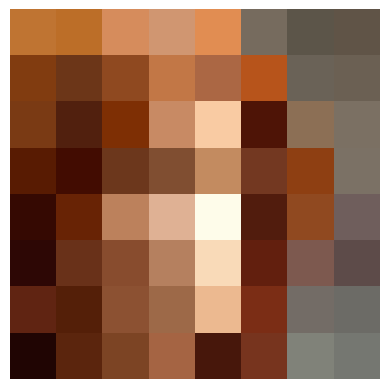

Scale 16x16:


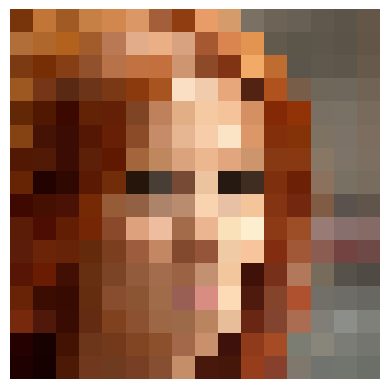

Scale 32x32:


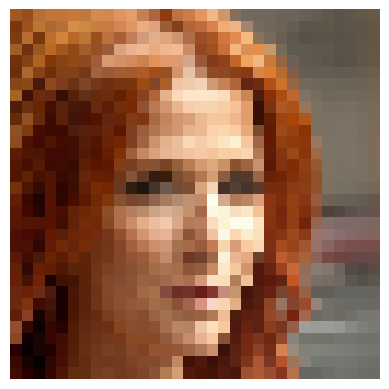

Scale 64x64:


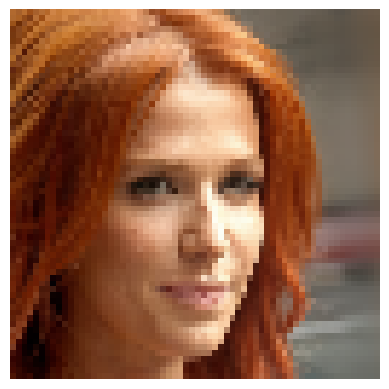

Scale 128x128:


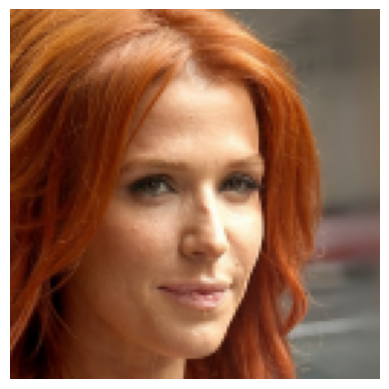

Scale 256x256:


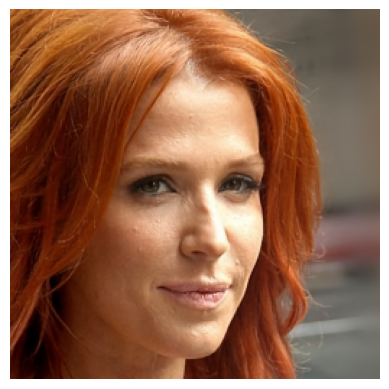

In [11]:
# test scaling
scaled_images = generate_image_scales("/content/drive/My Drive/aml/celebAhq256small/img_2.png")
for i, scaled in enumerate(scaled_images):
     print(f"Scale {2**(i+3)}x{2**(i+3)}:")
     plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))
     plt.axis('off')
     plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils, models
import torch.nn.functional as F

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        # Add the skip connection
        return x + self.conv_block(x)
    # no padding
    '''def forward(self, x):
        # Crop the input to match the reduced dimensions
        cropped_input = x[:, :, 2:-2, 2:-2]
        return cropped_input + self.conv_block(x)'''


In [14]:
class MultiScaleCombiner(nn.Module):
    """
    Combines multiscale branches via nearest-neighbor upsampling and concatenation.
    """
    def __init__(self):
        super(MultiScaleCombiner, self).__init__()

    def forward(self, branches):
        """
        Forward pass for combining branches.

        Parameters:
            branches (list of torch.Tensor): A list of tensors from different branches
                                              (e.g., [8x8, 16x16, 32x32, ...]).

        Returns:
            torch.Tensor: The combined tensor after upsampling and concatenation.
        """
        # Upsample all branches to match the resolution of the largest branch
        max_size = branches[-1].shape[2:]  # Spatial size of the largest branch (H, W)
        upsampled_branches = [
            F.interpolate(branch, size=max_size, mode='nearest') for branch in branches
        ]

        # Concatenate along the channel axis
        combined = torch.cat(upsampled_branches, dim=1)  # Concatenate channels

        return combined

In [24]:
class MultiScaleTransformationNetwork(nn.Module):
    """
    Multiscale transformation network as described in the paper.
    """
    def __init__(self, num_residual_blocks=2):
        super(MultiScaleTransformationNetwork, self).__init__()

        # Define branches for each scale
        self.branch_8x8 = self._make_branch(3, 32, num_residual_blocks)  # 3 input channels (RGB)
        self.branch_16x16 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_32x32 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_64x64 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_128x128 = self._make_branch(3, 32, num_residual_blocks)

        # Multiscale combiner
        self.combiner = MultiScaleCombiner()

        # Final output layer
        self.final_conv = nn.Conv2d(160, 3, kernel_size=1, stride=1, padding=0)

    def _make_branch(self, in_channels, out_channels, num_blocks):
        """
        Creates a branch with an initial convolution and a sequence of residual blocks.

        Parameters:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels for the initial convolution.
            num_blocks (int): Number of residual blocks in the branch.

        Returns:
            nn.Sequential: A branch with an initial convolution and residual blocks.
        """
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Initial conv
            nn.ReLU(inplace=True)
        ]
        layers += [ResidualBlock(out_channels) for _ in range(num_blocks)]  # Residual blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass for the multiscale transformation network.

        Parameters:
            x (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Transformed tensor of shape (B, 3, H, W).
        """
        # Downsample input to each scale
        branch_inputs = [
            F.interpolate(x, size=(8, 8), mode='nearest'),
            F.interpolate(x, size=(16, 16), mode='nearest'),
            F.interpolate(x, size=(32, 32), mode='nearest'),
            F.interpolate(x, size=(64, 64), mode='nearest'),
            F.interpolate(x, size=(128, 128), mode='nearest'),
        ]

        # Process each scale through its branch
        branch_outputs = [
            self.branch_8x8(branch_inputs[0]),
            self.branch_16x16(branch_inputs[1]),
            self.branch_32x32(branch_inputs[2]),
            self.branch_64x64(branch_inputs[3]),
            self.branch_128x128(branch_inputs[4]),
        ]

        # Visualize branch outputs
        '''for i, branch_output in enumerate(branch_outputs):
            # Select a single channel (e.g., the first channel)
            branch_image = branch_output[0, 0].cpu().detach().numpy()  # Select batch=0, channel=0
            plt.imshow(branch_image, cmap='gray')  # Grayscale visualization
            plt.title(f"Branch Output: {2**(i+3)}x{2**(i+3)} - Channel 0")
            plt.axis("off")
            plt.show()'''


        # Combine all branches
        combined_features = self.combiner(branch_outputs)

        # Final convolution to produce RGB output
        output = self.final_conv(combined_features)

        return output


In [25]:
# Create the network
net = MultiScaleTransformationNetwork()

# Example input image (batch size 1, 3 channels, 256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass
output_tensor = net(input_tensor)

print("Output shape:", output_tensor.shape)  # Should be (1, 3, 256, 256)


Output shape: torch.Size([1, 3, 128, 128])


# Loss

In [26]:
# Loss functions

# Define the VGG model for perceptual loss
class VGGFeatures(nn.Module):
    def __init__(self, layer_ids=[4, 9, 16, 23]):
        """
        Extracts features from a pre-trained VGG network.

        Parameters:
            layer_ids (list): Indices of layers to extract features from.
        """
        super(VGGFeatures, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.layer_ids = layer_ids
        self.model = vgg[:max(layer_ids) + 1]  # Keep layers up to the maximum requested layer

        # Freeze VGG weights
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.model):
            x = layer(x)  # Pass through each layer
            if i in self.layer_ids:  # Collect features at the specified layers
                features.append(x)
        return features

# Content Loss
def content_loss(source_features, transformed_features):
    """
    Computes the content loss between source and transformed features.

    Parameters:
        source_features (list): List of feature maps from source image.
        transformed_features (list): List of feature maps from transformed image.

    Returns:
        torch.Tensor: Content loss.
    """
    loss = 0.0
    for src_feat, trans_feat in zip(source_features, transformed_features):
        loss += F.mse_loss(trans_feat, src_feat)
    return loss

# Gram Matrix for Style Loss
def gram_matrix(features):
    """
    Computes the Gram matrix of the input features.

    Parameters:
        features (torch.Tensor): Feature map of shape (B, C, H, W).

    Returns:
        torch.Tensor: Gram matrix of shape (B, C, C).
    """
    B, C, H, W = features.size()
    features = features.view(B, C, H * W)
    return torch.bmm(features, features.transpose(1, 2)) / (C * H * W)

# Style Loss
def style_loss(target_features, transformed_features):
    """
    Computes the style loss between target and transformed features.

    Parameters:
        target_features (list): List of feature maps from target image.
        transformed_features (list): List of feature maps from transformed image.

    Returns:
        torch.Tensor: Style loss.
    """
    loss = 0.0
    for target_feat, trans_feat in zip(target_features, transformed_features):
        target_gram = gram_matrix(target_feat)
        trans_gram = gram_matrix(trans_feat)
        loss += F.mse_loss(trans_gram, target_gram)
    return loss

# Total Variation Loss
def total_variation_loss(image):
    """
    Computes the total variation loss to encourage smoothness in the image.

    Parameters:
        image (torch.Tensor): Input image of shape (B, C, H, W).

    Returns:
        torch.Tensor: Total variation loss.
    """
    loss = torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss


In [27]:
# Initialize the feature extractor
vgg_extractor = VGGFeatures(layer_ids=[4, 9, 16, 23])  # Specify layers for feature extraction

# Example inputs (ensure they are resized to match VGG input requirements)
source_image = torch.randn(1, 3, 256, 256)
target_image = torch.randn(1, 3, 256, 256)
transformed_image = torch.randn(1, 3, 256, 256)

# Extract features
source_features = vgg_extractor(source_image)
target_features = vgg_extractor(target_image)
transformed_features = vgg_extractor(transformed_image)

# Compute losses
content = content_loss(source_features, transformed_features)
style = style_loss(target_features, transformed_features)
tv = total_variation_loss(transformed_image)

print(f"Content Loss: {content.item()}, Style Loss: {style.item()}, TV Loss: {tv.item()}")


Content Loss: 61.524681091308594, Style Loss: 7.989269215613604e-05, TV Loss: 442998.875


# Training Loop

In [38]:
# Define the training function
def train_transformation_network(model, dataloader, vgg_extractor, optimizer, num_epochs=10, device="cuda"):
    """
    Trains the transformation network.

    Parameters:
        model (nn.Module): Transformation network.
        dataloader (DataLoader): Dataloader for source and target images.
        vgg_extractor (nn.Module): VGG feature extractor for perceptual loss.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs for training.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        None
    """
    model.to(device)
    vgg_extractor.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_content_loss = 0
        epoch_style_loss = 0
        epoch_tv_loss = 0

        for batch_idx, (source_images, target_images) in enumerate(dataloader):
            # Move data to device
            source_images = source_images.to(device)
            target_images = target_images.to(device)

            # Forward pass: Generate transformed images
            transformed_images = model(source_images)

            # Resize images for VGG feature extraction
            source_resized = F.interpolate(source_images, size=(256, 256), mode="bilinear", align_corners=False)
            target_resized = F.interpolate(target_images, size=(256, 256), mode="bilinear", align_corners=False)
            transformed_resized = F.interpolate(transformed_images, size=(256, 256), mode="bilinear", align_corners=False)

            # Extract features
            source_features = vgg_extractor(source_resized)
            target_features = vgg_extractor(target_resized)
            transformed_features = vgg_extractor(transformed_resized)


            '''# Extract features for content and style loss
            source_features = vgg_extractor(source_images)
            target_features = vgg_extractor(target_images)
            transformed_features = vgg_extractor(transformed_images)'''

            # Compute losses
            content = content_loss(source_features, transformed_features)
            style = style_loss(target_features, transformed_features)
            tv = total_variation_loss(transformed_images)

            # Total loss
            # total_loss = content + 1 * style + 0.1 * tv
            # total_loss = 1.0 * content + 10.0 * style + 0.05 * tv
            total_loss = 1.0 * content + 10.0 * style + 0.001 * tv


            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Accumulate losses for monitoring
            epoch_content_loss += content.item()
            epoch_style_loss += style.item()
            epoch_tv_loss += tv.item()

            # Print progress
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}]: "
                    f"Content Loss: {content.item():.4f}, Style Loss: {style.item():.4f}, TV Loss: {tv.item():.4f}"
                )
                plt.imshow(transformed_images[0].permute(1, 2, 0).cpu().detach().numpy())
                plt.title(f"Transformed Image at Batch {batch_idx}")
                plt.axis("off")
                plt.show()

        # Print epoch summary
        print(
            f"Epoch [{epoch+1}/{num_epochs}] Summary: "
            f"Content Loss: {epoch_content_loss / len(dataloader):.4f}, "
            f"Style Loss: {epoch_style_loss / len(dataloader):.4f}, "
            f"TV Loss: {epoch_tv_loss / len(dataloader):.4f}"
        )

        # Save model checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"transformation_network_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")


# Dataloader

In [39]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Dataset for loading source and target images from the same directory.

        Parameters:
            image_dir (str): Directory containing face images.
            transform (callable, optional): Transformation to apply to images.
        """
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Randomly select a different image as the target
        target_idx = idx
        while target_idx == idx:
            target_idx = np.random.randint(0, len(self.image_paths))

        # Load source and target images
        source_image = cv2.imread(self.image_paths[idx])
        target_image = cv2.imread(self.image_paths[target_idx])

        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image


'''# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Dataset and Dataloader
source_dir = "/content/drive/My Drive/aml/sources"
target_dir = "/content/drive/My Drive/aml/celebAhq256/train"

dataset = FaceDataset(source_dir, target_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)'''

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and Dataloader
image_dir = "/content/drive/My Drive/aml/celebAhq256/train"
dataset = FaceDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# Check dataset
for i, (source, target) in enumerate(dataloader):
    print(f"Source shape: {source.shape}, Target shape: {target.shape}")
    if i == 5:  # Check a few samples
        break




Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])
Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])
Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])
Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])
Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])
Source shape: torch.Size([100, 3, 256, 256]), Target shape: torch.Size([100, 3, 256, 256])


Epoch [1/10], Batch [1/134]: Content Loss: 21232.9922, Style Loss: 1295.5946, TV Loss: 67758560.0000


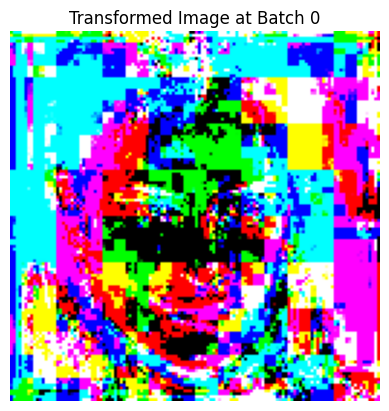

Epoch [1/10], Batch [101/134]: Content Loss: 14576.9551, Style Loss: 565.1696, TV Loss: 56710768.0000


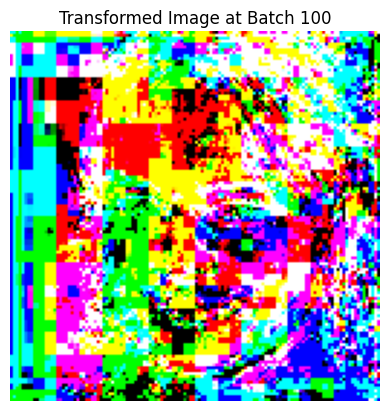

Epoch [1/10] Summary: Content Loss: 16585.5497, Style Loss: 763.7453, TV Loss: 60149052.7761


Epoch [2/10], Batch [1/134]: Content Loss: 12982.8574, Style Loss: 456.5578, TV Loss: 53370432.0000


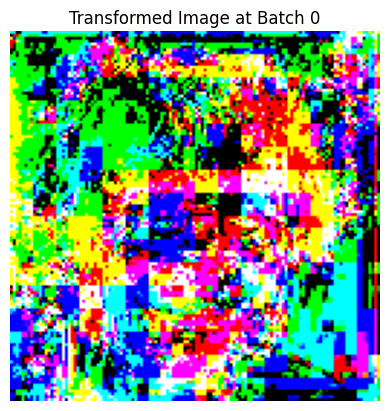

Epoch [2/10], Batch [101/134]: Content Loss: 9560.6309, Style Loss: 233.8329, TV Loss: 44693524.0000


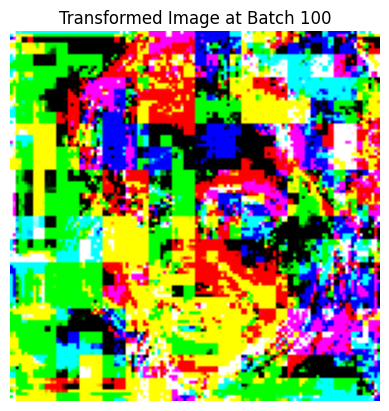

Epoch [2/10] Summary: Content Loss: 10698.2256, Style Loss: 305.0529, TV Loss: 47467495.0299


Epoch [3/10], Batch [1/134]: Content Loss: 8668.3125, Style Loss: 193.1718, TV Loss: 42506320.0000


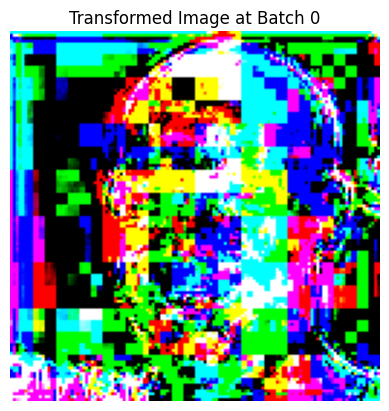

Epoch [3/10], Batch [101/134]: Content Loss: 6906.1396, Style Loss: 122.3010, TV Loss: 37520184.0000


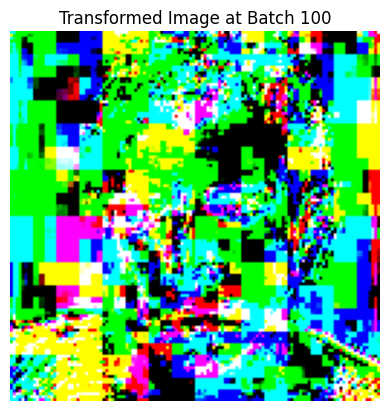

Epoch [3/10] Summary: Content Loss: 7400.7128, Style Loss: 142.6010, TV Loss: 38356947.6119


Epoch [4/10], Batch [1/134]: Content Loss: 6026.4692, Style Loss: 92.8800, TV Loss: 34022544.0000


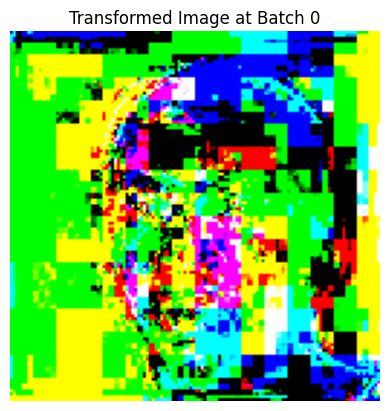

Epoch [4/10], Batch [101/134]: Content Loss: 4955.9116, Style Loss: 65.7879, TV Loss: 31055134.0000


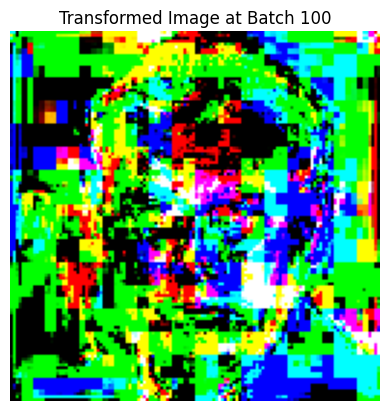

Epoch [4/10] Summary: Content Loss: 5285.0562, Style Loss: 72.7104, TV Loss: 31602987.1791


Epoch [5/10], Batch [1/134]: Content Loss: 4514.5610, Style Loss: 52.1107, TV Loss: 29199504.0000


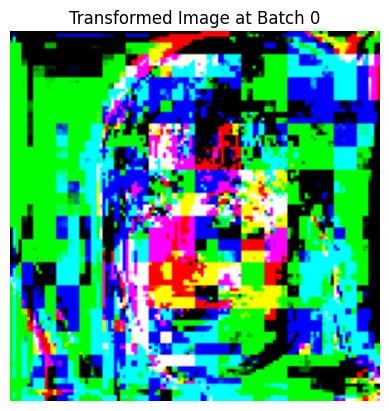

Epoch [5/10], Batch [101/134]: Content Loss: 3483.5151, Style Loss: 32.4696, TV Loss: 25322988.0000


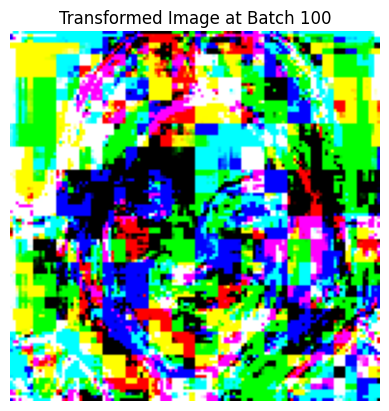

Epoch [5/10] Summary: Content Loss: 3864.8613, Style Loss: 39.6143, TV Loss: 26591361.5672
Saved checkpoint: transformation_network_epoch_5.pth


Epoch [6/10], Batch [1/134]: Content Loss: 3407.3960, Style Loss: 31.4843, TV Loss: 25249874.0000


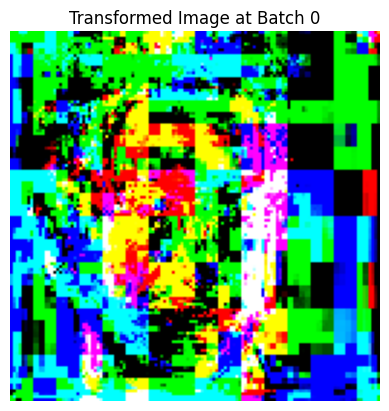

Epoch [6/10], Batch [101/134]: Content Loss: 2768.6101, Style Loss: 20.5889, TV Loss: 22141960.0000


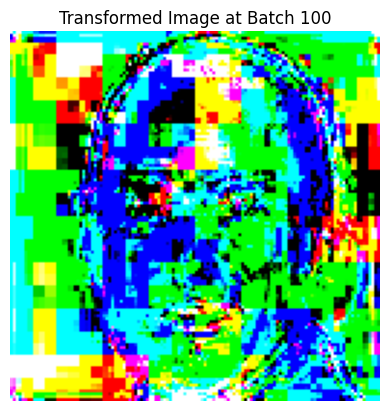

Epoch [6/10] Summary: Content Loss: 2948.4027, Style Loss: 23.5538, TV Loss: 22943858.8284


Epoch [7/10], Batch [1/134]: Content Loss: 2640.1128, Style Loss: 18.8939, TV Loss: 21346310.0000


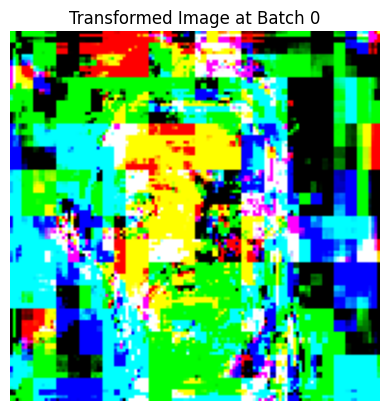

Epoch [7/10], Batch [101/134]: Content Loss: 2177.7107, Style Loss: 13.1400, TV Loss: 19693562.0000


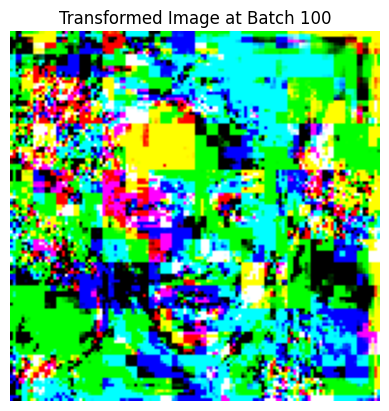

Epoch [7/10] Summary: Content Loss: 2319.3196, Style Loss: 14.8513, TV Loss: 20180397.2836


Epoch [8/10], Batch [1/134]: Content Loss: 2043.5973, Style Loss: 11.6644, TV Loss: 19175842.0000


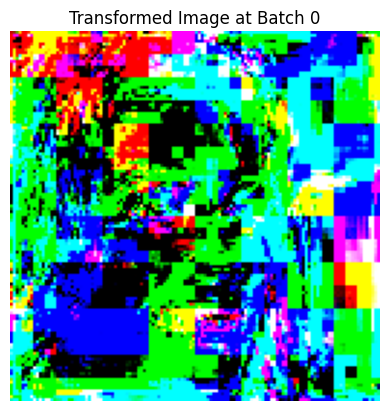

Epoch [8/10], Batch [101/134]: Content Loss: 1889.3502, Style Loss: 9.8372, TV Loss: 17883004.0000


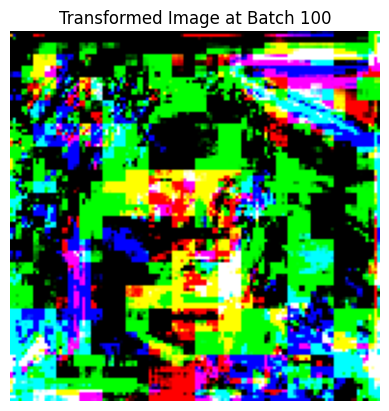

Epoch [8/10] Summary: Content Loss: 1860.4218, Style Loss: 9.7321, TV Loss: 17980886.0224


Epoch [9/10], Batch [1/134]: Content Loss: 1655.0603, Style Loss: 7.7731, TV Loss: 17358758.0000


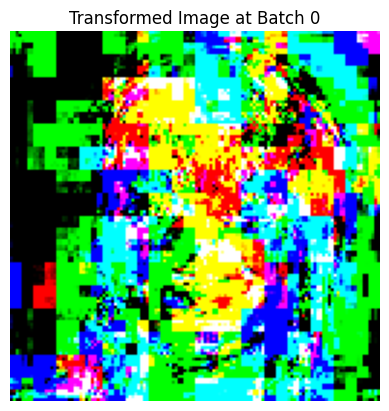

Epoch [9/10], Batch [101/134]: Content Loss: 1413.1729, Style Loss: 5.9318, TV Loss: 15621404.0000


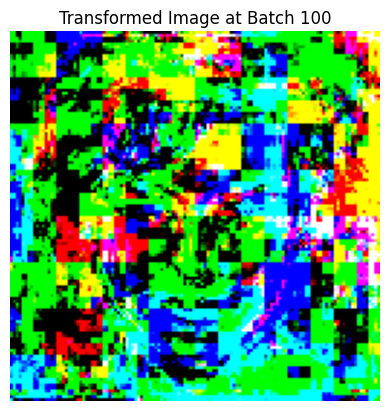

Epoch [9/10] Summary: Content Loss: 1513.9635, Style Loss: 6.5755, TV Loss: 16149906.0075


Epoch [10/10], Batch [1/134]: Content Loss: 1334.4746, Style Loss: 5.2567, TV Loss: 15222274.0000


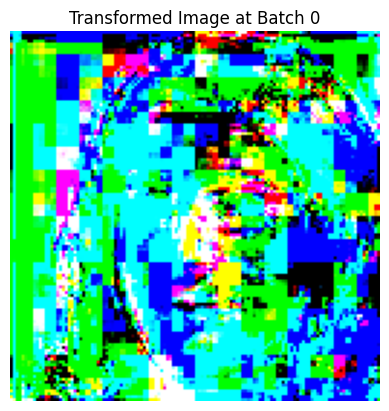

Epoch [10/10], Batch [101/134]: Content Loss: 1201.4785, Style Loss: 4.2856, TV Loss: 14741034.0000


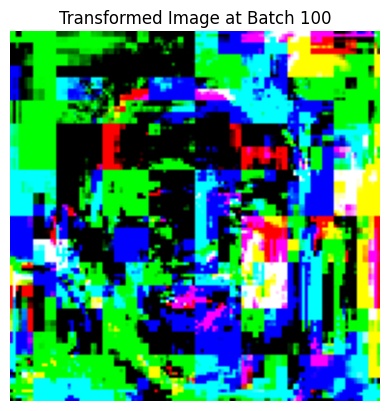

Epoch [10/10] Summary: Content Loss: 1253.9154, Style Loss: 4.5874, TV Loss: 14597432.9925
Saved checkpoint: transformation_network_epoch_10.pth
Model saved to /content/drive/My Drive/aml/transformation_network_epoch_10.pth


In [40]:
# Initialize the network
model = MultiScaleTransformationNetwork()


# Apply the custom weight initialization
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

model.apply(initialize_weights)


# Initialize the VGG feature extractor
vgg_extractor = VGGFeatures(layer_ids=[4, 9, 16, 23])

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train_transformation_network(
    model=model,
    dataloader=dataloader,
    vgg_extractor=vgg_extractor,
    optimizer=optimizer,
    num_epochs=10,
    device="cuda"
)

# Save the model checkpoint
checkpoint_path = "/content/drive/My Drive/aml/transformation_network_epoch_10.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Model saved to {checkpoint_path}") # Ensure the model is on the same device



In [41]:
import matplotlib.pyplot as plt

def test_model_with_target(model, source_image_path, target_image_path, device="cuda"):
    """
    Tests the trained transformation network on a source and target image.

    Parameters:
        model (nn.Module): Trained transformation network.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image (for visualization).
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        None: Displays the transformed image.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    # Load and preprocess the source and target images
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    source_image = cv2.imread(source_image_path)
    target_image = cv2.imread(target_image_path)

    source_tensor = transform(source_image).unsqueeze(0).to(device)  # Add batch dimension
    target_tensor = transform(target_image).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        transformed_tensor = model(source_tensor)

    # Denormalize the output for visualization
    transformed_tensor = transformed_tensor.squeeze(0)  # Remove batch dimension
    transformed_image = transformed_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to HWC
    transformed_image = (transformed_image * 0.5 + 0.5) * 255  # Denormalize and scale to [0, 255]
    transformed_image = transformed_image.astype(np.uint8)

    # Visualize the source, target, and transformed image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
    plt.title("Source Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
    plt.title("Target Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Transformed Image")
    plt.axis("off")

    plt.show()



<ipython-input-42-47e4a8f0a310>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/aml/transformation_network_epoch_1

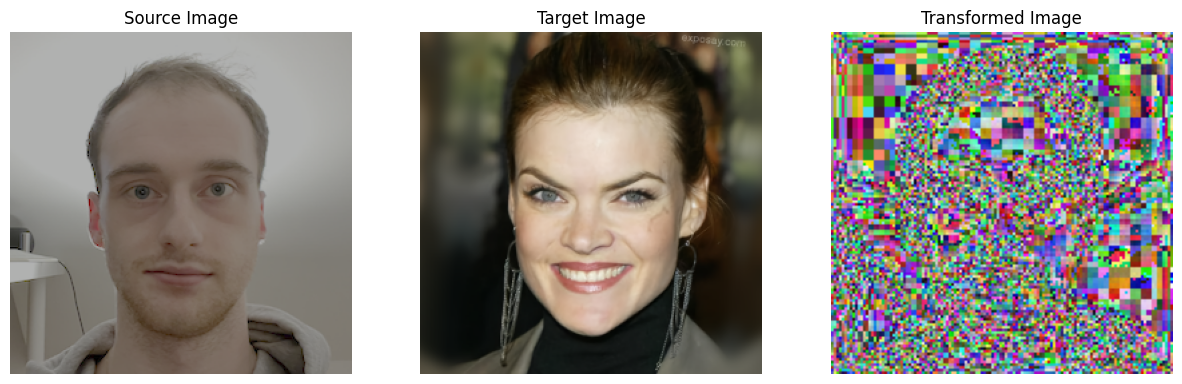

In [42]:
# Paths to source and target images
source_image_path = "/content/drive/My Drive/aml/sources/source_1.png"
target_image_path = "/content/drive/My Drive/aml/celebAhq256small/img_0.png"

# Load the trained model
model = MultiScaleTransformationNetwork()
model.load_state_dict(torch.load("/content/drive/My Drive/aml/transformation_network_epoch_10.pth"))
model.to("cuda")

# Test the model
test_model_with_target(model, source_image_path, target_image_path)


In [43]:
print(f"Dataset size: {len(dataloader.dataset)}")


Dataset size: 13372
